### Binary Classification Model for Kaggle Tabular Playground Series March 2021 Using TensorFlow Decision Forests
### David Lowe
### November 12, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Mar 2021 dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset may be synthetic but is based on a real dataset and generated using a CTGAN. The original dataset tries to predict the amount of an insurance claim. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: The performance of the preliminary Gradient Boosted Trees model achieved a ROC/AUC benchmark of 0.8724 on the validation dataset. The final model processed the validation dataset with a final ROC/AUC score of 0.8753. When we applied the finalized model to Kaggle's test dataset, the model achieved a ROC/AUC score of 0.8864.

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 March Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-mar-2021

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-mar-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Train and Evaluate Models
4. Fine-tune and Improve Models
5. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL
!pip install tensorflow_decision_forests

In [2]:
!pip install wurlitzer

In [3]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [4]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [5]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [7]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
import tensorflow_decision_forests as tfdf

In [8]:
try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

### 1.b) Set up the controlling parameters and functions

In [9]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
# DEFAULT_METRICS = [tf.keras.metrics.AUC()]
DEFAULT_METRICS = ["accuracy", tf.keras.metrics.AUC()]
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.00005)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCHS = 50
BATCH_SIZE = 32

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Num GPUs Available: 0
TensorFlow version: 2.7.0
Found TensorFlow Decision Forests v0.2.1


In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [13]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021mar/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id cat0 cat1 cat2 cat3  ...     cont7     cont8     cont9    cont10 target
0   0    A    I    A    B  ...  0.791921  0.815254  0.965006  0.665915      0
1   1    A    I    A    A  ...  0.408701  0.399353  0.927406  0.493729      0
2   2    A    K    A    A  ...  0.388835  0.412303  0.292696  0.549452      0
3   3    A    K    A    C  ...  0.897617  0.633669  0.760318  0.934242      0
4   4    A    I    G    B  ...  0.279167  0.351103  0.357084  0.328960      1

[5 rows x 32 columns]


In [14]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cat10   300000 non-null  object 
 12  cat11   300000 non-null  object 
 13  cat12   300000 non-null  object 
 14  cat13   300000 non-null  object 
 15  cat14   300000 non-null  object 
 16  cat15   300000 non-null  object 
 17  cat16   300000 non-null  object 
 18  cat17   300000 non-null  object 
 19  cat18   300000 non-null  object 
 20  cont0   300000 non-null  float64
 21  cont1   30

In [15]:
print(df_dataset_import.describe())

                  id          cont0  ...         cont10         target
count  300000.000000  300000.000000  ...  300000.000000  300000.000000
mean   250183.425697       0.504749  ...       0.508230       0.264870
std    144320.334812       0.206788  ...       0.203393       0.441265
min         0.000000      -0.049562  ...       0.097789       0.000000
25%    125399.750000       0.344985  ...       0.368312       0.000000
50%    250192.500000       0.479650  ...       0.446576       0.000000
75%    375246.250000       0.637657  ...       0.581957       1.000000
max    499999.000000       1.004559  ...       1.011331       1.000000

[8 rows x 13 columns]


In [16]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [17]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

  cat0 cat1 cat2 cat3 cat4  ...     cont7     cont8     cont9    cont10 target
0    A    I    A    B    B  ...  0.791921  0.815254  0.965006  0.665915      0
1    A    I    A    A    E  ...  0.408701  0.399353  0.927406  0.493729      0
2    A    K    A    A    E  ...  0.388835  0.412303  0.292696  0.549452      0
3    A    K    A    C    E  ...  0.897617  0.633669  0.760318  0.934242      0
4    A    I    G    B    E  ...  0.279167  0.351103  0.357084  0.328960      1

[5 rows x 31 columns]


In [18]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cat10   300000 non-null  object 
 11  cat11   300000 non-null  object 
 12  cat12   300000 non-null  object 
 13  cat13   300000 non-null  object 
 14  cat14   300000 non-null  object 
 15  cat15   300000 non-null  object 
 16  cat16   300000 non-null  object 
 17  cat17   300000 non-null  object 
 18  cat18   300000 non-null  object 
 19  cont0   300000 non-null  float64
 20  cont1   300000 non-null  float64
 21  cont2   30

In [19]:
print(df_dataset_import.describe())

               cont0          cont1  ...         cont10         target
count  300000.000000  300000.000000  ...  300000.000000  300000.000000
mean        0.504749       0.494073  ...       0.508230       0.264870
std         0.206788       0.213037  ...       0.203393       0.441265
min        -0.049562       0.084480  ...       0.097789       0.000000
25%         0.344985       0.317363  ...       0.368312       0.000000
50%         0.479650       0.463170  ...       0.446576       0.000000
75%         0.637657       0.693992  ...       0.581957       1.000000
max         1.004559       1.009958  ...       1.011331       1.000000

[8 rows x 12 columns]


In [20]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [21]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (300000, 31) df_features_train.shape: (300000, 30) df_target_train.shape: (300000,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

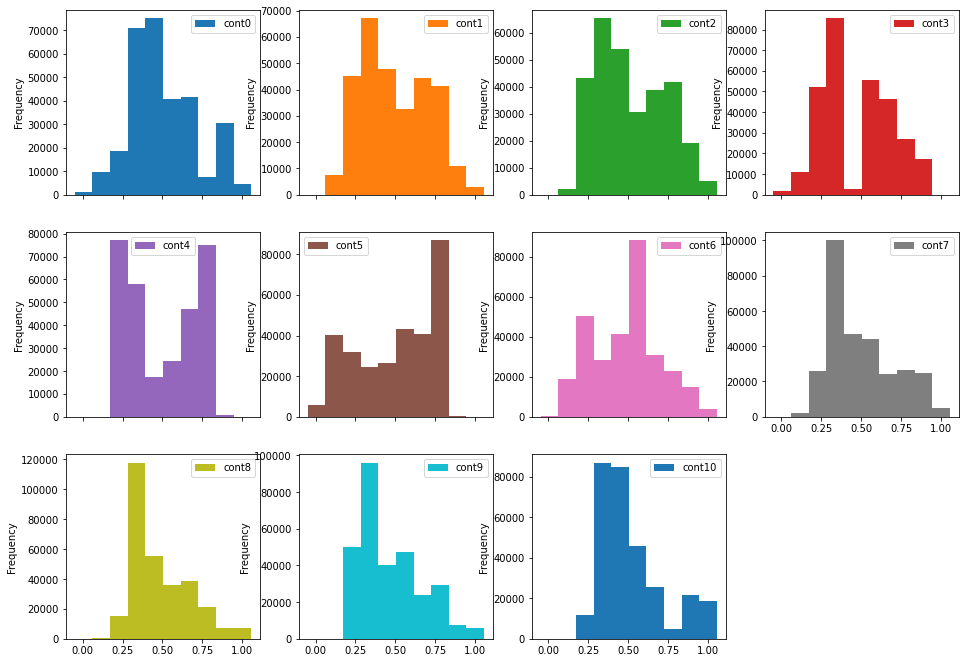

In [25]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

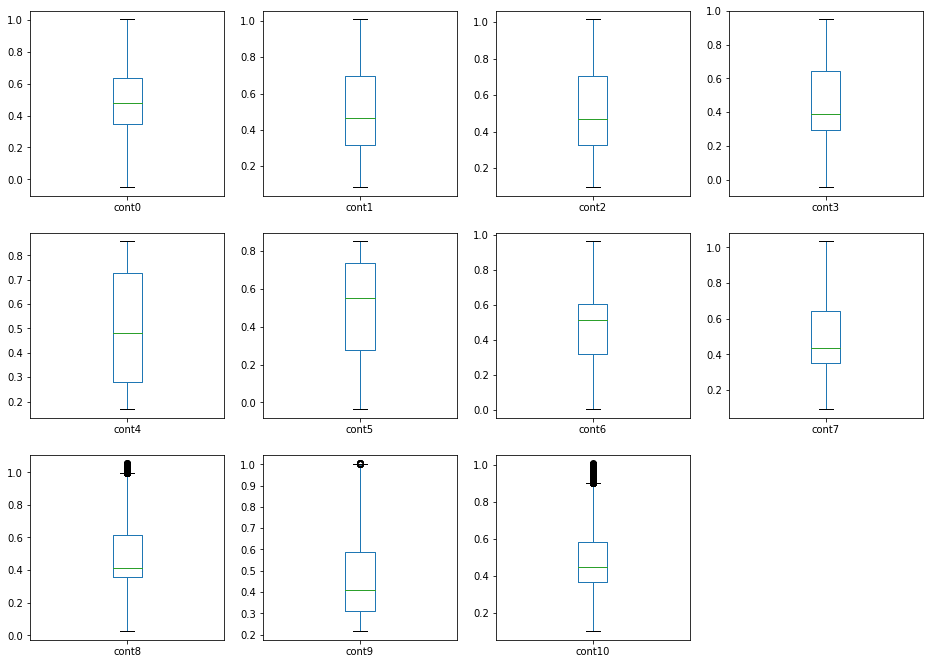

In [26]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

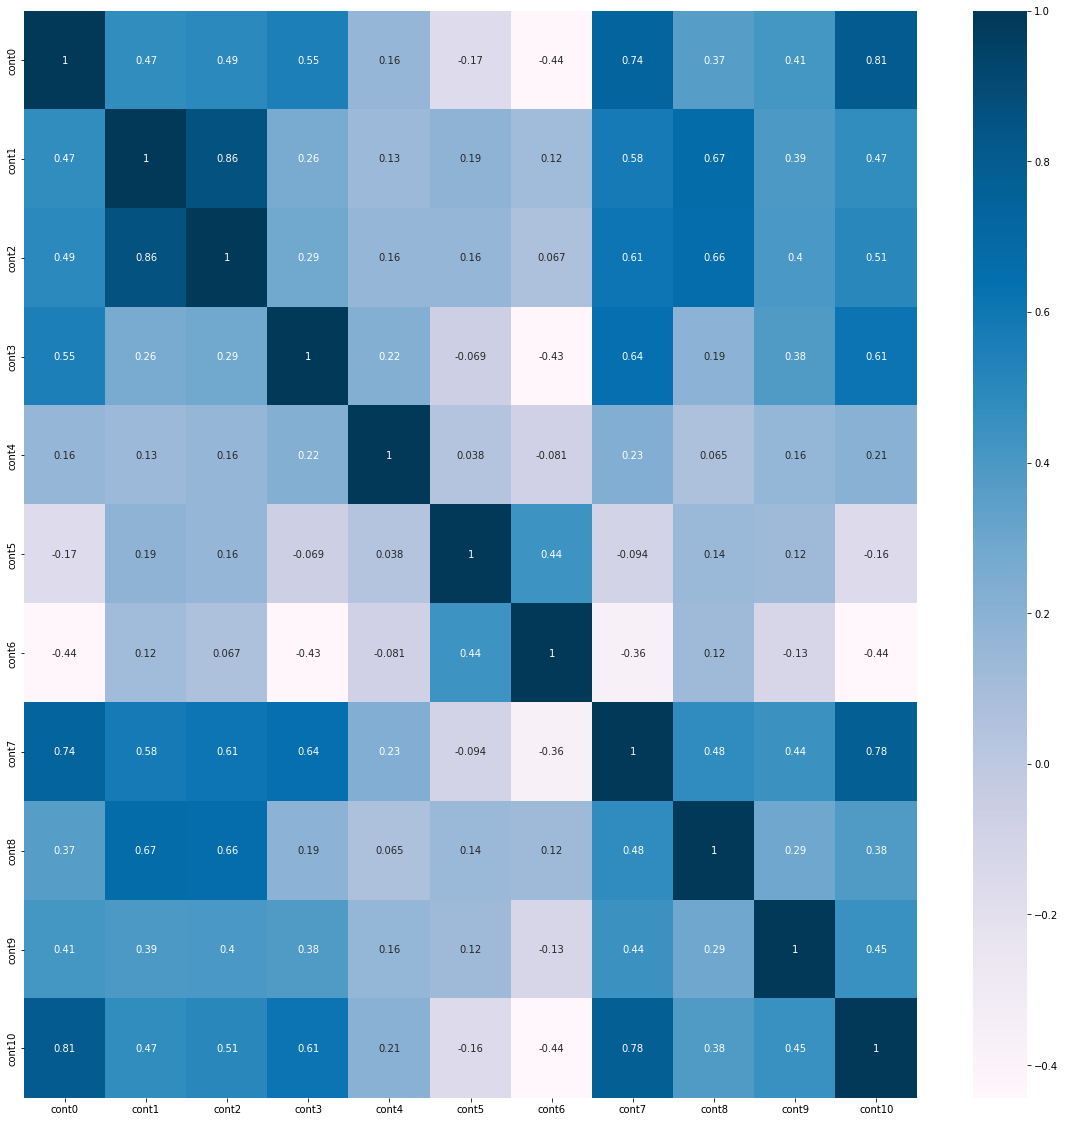

In [27]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [29]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [30]:
# Split the data further into training and validation datasets
df_dataset_train, df_dataset_valid = train_test_split(df_dataset_import, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
print("df_dataset_train.shape: {} df_dataset_valid.shape: {}".format(df_dataset_train.shape, df_dataset_valid.shape))

df_dataset_train.shape: (270000, 31) df_dataset_valid.shape: (30000, 31)


In [31]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task=tfdf.keras.Task.CLASSIFICATION)
tfds_valid = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_valid, label='target', task=tfdf.keras.Task.CLASSIFICATION)

### 3.b) Train and Evaluate the Random Forest Model

In [32]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
model_1 = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_1.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_1.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

4215/4219 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4219
[INFO kernel.cc:393] Number of examples: 270000
[INFO data_spec_inference.cc:290] 37 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat10 (259 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 270000
Number of columns: 31

Number of columns by type:
	CATEGORICAL: 20 (64.5161%)
	NUMERICAL: 11 (35.4839%)

Columns:

CATEGORICAL: 20 (64.5161%)
	0: "cat0" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 201121 (74.4893%)
	1: "cat1" CATEGORICAL has-dict vocab-size:16 zero-ood-items most-frequent:"I" 81640 (30.237%)
	2: "cat10" CATEGORICAL has-dict vocab-size:260 num-oods:37 (0.0137037%) most-frequent:"DJ" 28492 (10.5526%)
	3: "cat11" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 233048 (86.3141%)
	4:

4219/4219 [==============================] - 407s 95ms/step
Model training time: 0:06:49.937638 



In [33]:
tfdf.model_plotter.plot_model_in_colab(model_1)

In [34]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=270000, accuracy=0.8451, loss=0.7029741570276984, rmse=None, ndcg=None, aucs=None)

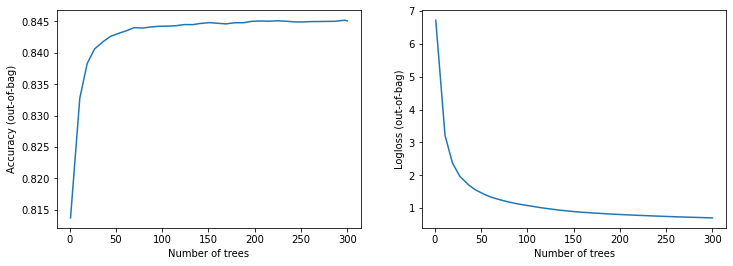

In [35]:
logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [36]:
evaluation = model_1.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

469/469 [==============================] - 12s 24ms/step - loss: 0.0000e+00 - accuracy: 0.8458 - auc: 0.8796

loss: 0.0000
accuracy: 0.8458
auc: 0.8796


### 3.c) Train and Evaluate the Decision Trees Model

In [37]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
model_2 = tfdf.keras.CartModel(task=tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_2.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_2.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

4214/4219 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4219
[INFO kernel.cc:393] Number of examples: 270000
[INFO data_spec_inference.cc:290] 37 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat10 (259 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 270000
Number of columns: 31

Number of columns by type:
	CATEGORICAL: 20 (64.5161%)
	NUMERICAL: 11 (35.4839%)

Columns:

CATEGORICAL: 20 (64.5161%)
	0: "cat0" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 201121 (74.4893%)
	1: "cat1" CATEGORICAL has-dict vocab-size:16 zero-ood-items most-frequent:"I" 81640 (30.237%)
	2: "cat10" CATEGORICAL has-dict vocab-size:260 num-oods:37 (0.0137037%) most-frequent:"DJ" 28492 (10.5526%)
	3: "cat11" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 233048 (86.3141%)
	4:

4219/4219 [==============================] - 21s 5ms/step
Model training time: 0:00:21.168531 



In [38]:
tfdf.model_plotter.plot_model_in_colab(model_2)

In [39]:
model_2.make_inspector().evaluation()

In [40]:
evaluation = model_2.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

469/469 [==============================] - 2s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8341 - auc: 0.8614

loss: 0.0000
accuracy: 0.8341
auc: 0.8614


### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [41]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
model_3 = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_3.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_3.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

4215/4219 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4219
[INFO kernel.cc:393] Number of examples: 270000
[INFO data_spec_inference.cc:290] 37 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat10 (259 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 270000
Number of columns: 31

Number of columns by type:
	CATEGORICAL: 20 (64.5161%)
	NUMERICAL: 11 (35.4839%)

Columns:

CATEGORICAL: 20 (64.5161%)
	0: "cat0" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 201121 (74.4893%)
	1: "cat1" CATEGORICAL has-dict vocab-size:16 zero-ood-items most-frequent:"I" 81640 (30.237%)
	2: "cat10" CATEGORICAL has-dict vocab-size:260 num-oods:37 (0.0137037%) most-frequent:"DJ" 28492 (10.5526%)
	3: "cat11" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 233048 (86.3141%)
	4:

4219/4219 [==============================] - 185s 44ms/step
Model training time: 0:03:23.117606 



In [42]:
tfdf.model_plotter.plot_model_in_colab(model_3)

In [43]:
model_3.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=0.8524239659309387, loss=0.6894564032554626, rmse=None, ndcg=None, aucs=None)

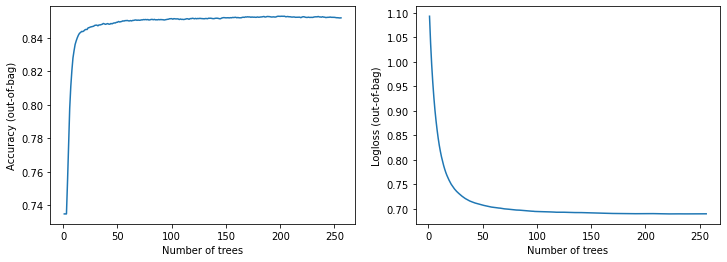

In [44]:
logs = model_3.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [45]:
evaluation = model_3.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

469/469 [==============================] - 3s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8487 - auc: 0.8689

loss: 0.0000
accuracy: 0.8487
auc: 0.8689


In [46]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [47]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [48]:
for num_trees in [300, 500, 750, 1000]:
    # Define the baseline model for benchmarking
    start_time_module = datetime.now()
    model_tune = tfdf.keras.RandomForestModel(num_trees=num_trees,
                                              task=tfdf.keras.Task.CLASSIFICATION)

    # Optionally, add evaluation metrics.
    model_tune.compile(metrics=DEFAULT_METRICS)

    # Train the model.
    model_tune.fit(x=tfds_train, verbose=False)

    evaluation = model_tune.evaluate(tfds_valid, return_dict=True)
    print()

    for name, value in evaluation.items():
        print(f"{name}: {value:.4f}")
    print ('Model optimization time:', (datetime.now() - start_time_module), '\n')

469/469 [==============================] - 11s 21ms/step - loss: 0.0000e+00 - accuracy: 0.8458 - auc: 0.8693

loss: 0.0000
accuracy: 0.8458
auc: 0.8693
Model optimization time: 0:06:59.135868 



469/469 [==============================] - 17s 36ms/step - loss: 0.0000e+00 - accuracy: 0.8462 - auc: 0.8704

loss: 0.0000
accuracy: 0.8462
auc: 0.8704
Model optimization time: 0:11:22.706131 



469/469 [==============================] - 27s 57ms/step - loss: 0.0000e+00 - accuracy: 0.8456 - auc: 0.8715

loss: 0.0000
accuracy: 0.8456
auc: 0.8715
Model optimization time: 0:17:25.075094 

469/469 [==============================] - 35s 72ms/step - loss: 0.0000e+00 - accuracy: 0.8459 - auc: 0.8724

loss: 0.0000
accuracy: 0.8459
auc: 0.8724
Model optimization time: 0:23:57.471925 



In [49]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [50]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [51]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_import, label='target')

In [52]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
final_model = tfdf.keras.GradientBoostedTreesModel(num_trees=1000,
                                                   task=tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
final_model.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

4687/4688 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4688
[INFO kernel.cc:393] Number of examples: 300000
[INFO data_spec_inference.cc:290] 36 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat10 (263 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 300000
Number of columns: 31

Number of columns by type:
	CATEGORICAL: 20 (64.5161%)
	NUMERICAL: 11 (35.4839%)

Columns:

CATEGORICAL: 20 (64.5161%)
	0: "cat0" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 223525 (74.5083%)
	1: "cat1" CATEGORICAL has-dict vocab-size:16 zero-ood-items most-frequent:"I" 90809 (30.2697%)
	2: "cat10" CATEGORICAL has-dict vocab-size:264 num-oods:36 (0.012%) most-frequent:"DJ" 31584 (10.528%)
	3: "cat11" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 258932 (86.3107%)
	4: "ca

4688/4688 [==============================] - 283s 60ms/step
Model training time: 0:04:43.912215 



In [53]:
final_model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (30):
	cat0
	cat1
	cat10
	cat11
	cat12
	cat13
	cat14
	cat15
	cat16
	cat17
	cat18
	cat2
	cat3
	cat4
	cat5
	cat6
	cat7
	cat8
	cat9
	cont0
	cont1
	cont10
	cont2
	cont3
	cont4
	cont5
	cont6
	cont7
	cont8
	cont9

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__LABEL"  4.923248 ################
    2.   "cat12"  4.908942 ###############
    3.   "cat11"  4.820095 ###############
    4.   "cat14"  4.765880 ##############
    5.    "cat0"  4.756178 ##############
    6.    "cat3"  4.733318 ##############
    7.   "cont0"  4.730982 ##############
    8.    "cat9"  4.721774 ##############
    9.   "cat17"  4.

In [54]:
tfdf.model_plotter.plot_model_in_colab(final_model)

In [55]:
final_model.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=0.851866602897644, loss=0.6838767528533936, rmse=None, ndcg=None, aucs=None)

In [56]:
evaluation = final_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

469/469 [==============================] - 3s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8695 - auc: 0.8753

loss: 0.0000
accuracy: 0.8695
auc: 0.8753


### 5.b) Load Test Dataset and Prepare the Submission File

In [57]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021mar/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

   id cat0 cat1 cat2 cat3  ...     cont6     cont7     cont8     cont9    cont10
0   5    A    F    A    A  ...  0.551249  0.655693  0.598331  0.359987  0.947489
1   6    A    H    C    A  ...  0.248987  0.654614  0.347944  0.565520  0.388580
2   8    A    N    C    A  ...  0.746740  0.335590  0.341238  0.252289  0.411592
3   9    B    L    C    A  ...  0.538724  0.381566  0.481660  0.348514  0.325723
4  11    A    F    A    B  ...  0.178920  0.763479  0.562491  0.466261  0.585781

[5 rows x 31 columns]


In [58]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

   id
0   5
1   6
2   8
3   9
4  11


In [59]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

  cat0 cat1 cat2 cat3 cat4  ...     cont6     cont7     cont8     cont9    cont10
0    A    F    A    A    F  ...  0.551249  0.655693  0.598331  0.359987  0.947489
1    A    H    C    A    E  ...  0.248987  0.654614  0.347944  0.565520  0.388580
2    A    N    C    A    F  ...  0.746740  0.335590  0.341238  0.252289  0.411592
3    B    L    C    A    F  ...  0.538724  0.381566  0.481660  0.348514  0.325723
4    A    F    A    B    F  ...  0.178920  0.763479  0.562491  0.466261  0.585781

[5 rows x 30 columns]


In [60]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_features_test)

In [61]:
# Make batched predictions
test_predictions = final_model.predict(tfds_test)
print(test_predictions)

[[0.13359067]
 [0.36941612]
 [0.0232612 ]
 ...
 [0.6553316 ]
 [0.1019013 ]
 [0.596915  ]]


In [62]:
df_kaggle_submission['target'] = test_predictions
print(df_kaggle_submission.head())

   id    target
0   5  0.133591
1   6  0.369416
2   8  0.023261
3   9  0.221062
4  11  0.094572


In [63]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20211109-2050.csv


In [64]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [65]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 2:01:36.309258
